In [12]:
import os
from os.path import join as oj
import sys, time
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from copy import deepcopy
import pickle as pkl
import pandas as pd
# plt.style.use('dark_background')
plt.style.use('seaborn-notebook')
from data_load_preprocess import data
from collections import OrderedDict


import torch
from torch.autograd import Variable
from viz import viz
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")

# load results from a directory

In [13]:
out_dir_main = '/scratch/users/vision/yu_dl/raaz.rsk/adam_vs_sgd'
print(os.listdir(out_dir_main))
folder = 'long_full'

['test_setup', 'long_full', 'long_sweep', 'simple_sweep']


In [14]:
out_dir = oj(out_dir_main, folder)
fnames = os.listdir(out_dir)
results_list = [pd.Series(pkl.load(open(oj(out_dir, fname), "rb"))) for fname in fnames]
results = pd.concat(results_list, axis=1).T.infer_objects()
# results.describe()
results.head()

,accs_test,beta1,beta2,eps,explained_var_dicts,explained_var_dicts_cosine,explained_var_dicts_lap,explained_var_dicts_rbf,gamma_optimizer,its,...,lr,num_iters,optimizer,out_dir,save_all_weights_freq,saves_per_iter,saves_per_iter_end,seed,step_size_optimizer,weights
0,"[0.114, 0.6639, 0.8194, 0.8138, 0.8492, 0.8783...",0.9,0.999,1.000000e-08,"[{'fc3.weight': [0.14545605, 0.1353643, 0.1309...","[{'fc3.weight': [0.16297232, 0.1526233, 0.1334...","[{'fc3.weight': [0.1417701613379656, 0.1275668...","[{'fc3.weight': [0.176243, 0.14096901, 0.12398...",0.9,"[0.0, 0.07692307692307693, 0.15384615384615385...",...,0.10,69,sgd,/scratch/users/vision/yu_dl/raaz.rsk/adam_vs_s...,100,13,5,0,1,{}
1,"[0.096, 0.8371, 0.86, 0.8873, 0.8837, 0.9161, ...",0.9,0.999,1.000000e-08,"[{'fc3.weight': [0.14595485, 0.14468428, 0.123...","[{'fc3.weight': [0.16444413, 0.15675682, 0.122...","[{'fc3.weight': [0.14622683383319174, 0.134651...","[{'fc3.weight': [0.18013418, 0.13656595, 0.125...",0.9,"[0.0, 0.07692307692307693, 0.15384615384615385...",...,0.01,69,adam,/scratch/users/vision/yu_dl/raaz.rsk/adam_vs_s...,100,13,5,2,1,{}
2,"[0.114, 0.8275, 0.8906, 0.8923, 0.9111, 0.9145...",0.9,0.999,1.000000e-08,"[{'fc2.weight': [0.011534997, 0.0113673145, 0....","[{'fc2.weight': [0.022366548, 0.021761706, 0.0...","[{'fc2.weight': [0.05332947415139581, 0.015919...","[{'fc2.weight': [0.11632629, 0.019762272, 0.01...",0.9,"[0.0, 0.07692307692307693, 0.15384615384615385...",...,0.01,69,adam,/scratch/users/vision/yu_dl/raaz.rsk/adam_vs_s...,100,13,5,0,1,{}
3,"[0.114, 0.2797, 0.3607, 0.3793, 0.4666, 0.5127...",0.9,0.999,1.000000e-08,"[{'fc3.weight': [0.14545605, 0.1353643, 0.1309...","[{'fc3.weight': [0.16297232, 0.1526233, 0.1334...","[{'fc3.weight': [0.1417701613379656, 0.1275668...","[{'fc3.weight': [0.176243, 0.14096901, 0.12398...",0.9,"[0.0, 0.07692307692307693, 0.15384615384615385...",...,0.01,69,sgd,/scratch/users/vision/yu_dl/raaz.rsk/adam_vs_s...,100,13,5,0,1,{}
4,"[0.0953, 0.8568, 0.8998, 0.8725, 0.9217, 0.925...",0.9,0.999,1.000000e-08,"[{'fc2.weight': [0.011183271, 0.0109710805, 0....","[{'fc2.weight': [0.021062147, 0.020346254, 0.0...","[{'fc2.weight': [0.04990655609713716, 0.015273...","[{'fc2.weight': [0.11026386, 0.01889671, 0.018...",0.9,"[0.0, 0.07692307692307693, 0.15384615384615385...",...,0.01,69,adam,/scratch/users/vision/yu_dl/raaz.rsk/adam_vs_s...,100,13,5,1,1,{}


# plot basic things for entire dataframe

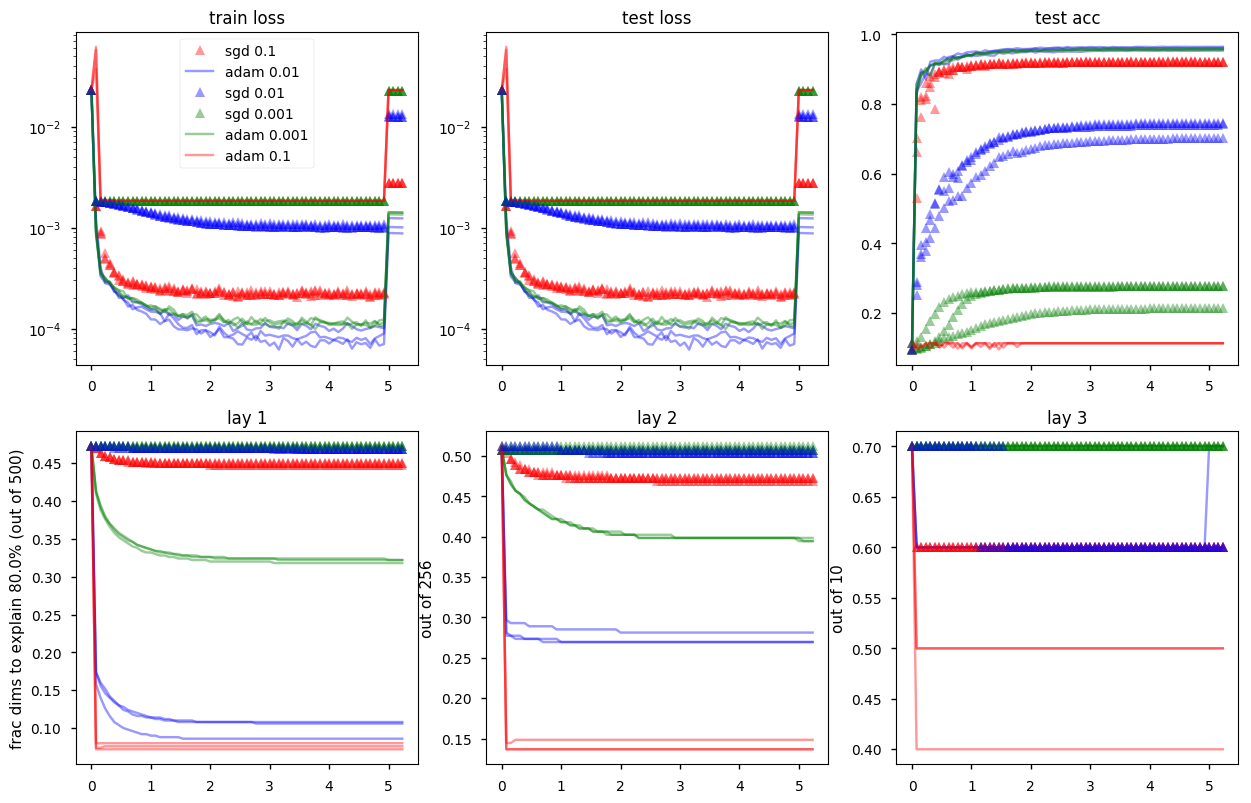

In [18]:
R, C = 3, 3
plt.figure(figsize=(9, 9), dpi=100)
percent_to_explain = 0.80

def frac_dims_to_explain_X_percent(arr, percent_to_explain):
    dim, perc_explained = 0, 0
    while perc_explained <= percent_to_explain:
        perc_explained += arr[dim]
        dim += 1
    return dim / arr.size
    

for index, row in results.iterrows():
    # style
    style = '^' if row.optimizer == 'sgd' else '-'
    color = {0.1: 'red', 0.01: 'blue', 0.001: 'green'}[row.lr]
    alpha = 0.4
    
    
    # accs
    plt.subplot(R, C, 1)
    plt.plot(row.its, row.losses_train, style, label= row.optimizer + ' ' + str(row.lr), color=color, alpha=alpha)
    plt.yscale('log')
    plt.title('train loss')
    
    plt.subplot(R, C, 2)
    plt.plot(row.its, row.losses_train, style, color=color, alpha=alpha)
    plt.yscale('log')    
    plt.title('test loss')
    
    plt.subplot(R, C, 3)
    plt.plot(row.its, row.accs_test, style, color=color, alpha=alpha)
    plt.title('test acc')
    
    
    # PCs
    plt.subplot(R, C, 4)
    plt.plot(row.its, [frac_dims_to_explain_X_percent(d['fc1.weight'], percent_to_explain) 
              for d in row.explained_var_dicts], style, color=color, alpha=alpha)
    plt.ylabel('frac dims to explain ' + str(100 * percent_to_explain) + '% (out of ' + str(row.explained_var_dicts[0]['fc1.weight'].size)+ ')')
    plt.title('lay 1')
    
    plt.subplot(R, C, 5)
    plt.plot(row.its, [frac_dims_to_explain_X_percent(d['fc2.weight'], percent_to_explain) 
              for d in row.explained_var_dicts], style, color=color, alpha=alpha)
    plt.title('lay 2')
    plt.ylabel('out of ' + str(row.explained_var_dicts[0]['fc2.weight'].size))
    
    plt.subplot(R, C, 6)
    plt.plot(row.its, [frac_dims_to_explain_X_percent(d['fc3.weight'], percent_to_explain) 
              for d in row.explained_var_dicts], style, color=color, alpha=alpha)
    plt.title('lay 3')
    plt.ylabel('out of ' + str(row.explained_var_dicts[0]['fc3.weight'].size))
    
    
    # PCs
    plt.subplot(R, C, 7)
    plt.plot(row.its, [frac_dims_to_explain_X_percent(d['fc1.weight'], percent_to_explain) 
              for d in row.explained_var_dicts_cosine], style, color=color, alpha=alpha)
    plt.ylabel('frac dims to explain ' + str(100 * percent_to_explain) + '% (out of ' + str(row.explained_var_dicts_cosine[0]['fc1.weight'].size)+ ')')
    plt.title('lay 1')
    
    plt.subplot(R, C, 8)
    plt.plot(row.its, [frac_dims_to_explain_X_percent(d['fc2.weight'], percent_to_explain) 
              for d in row.explained_var_dicts_cosine], style, color=color, alpha=alpha)
    plt.title('lay 2')
    plt.ylabel('out of ' + str(row.explained_var_dicts_cosine[0]['fc2.weight'].size))
    
    plt.subplot(R, C, 9)
    plt.plot(row.its, [frac_dims_to_explain_X_percent(d['fc3.weight'], percent_to_explain) 
              for d in row.explained_var_dicts_cosine], style, color=color, alpha=alpha)
    plt.title('lay 3')
    plt.ylabel('out of ' + str(row.explained_var_dicts_cosine[0]['fc3.weight'].size))   
    

plt.subplot(R, C, 1)    
# remove duplicate labels
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.show()